In [125]:
import sys

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install graphviz
!{sys.executable} -m pip install torch torchvision

import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [508]:
# wraps a value
class Value:
    # `()` is an empty tuple
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # derivative of L with respect to this value
        # 0 means "no effect" (gradient 0)
        self.grad = 0.0
        # default to nothing, on a leaf node there is nothing to do
        self._backward = lambda: None
        self._prev = set(_children) # set is cheaper than tuple
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
 
        return out
        
    # 2.__dd__(Value(3.0)) doesn't work
    # so python checks if Value has an `radd` that knows how to do it
    # "reverse add"
    def __radd__(self, other):
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): 
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # derivative of e^x is e^x
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # we could implement `__exp__` instead... but want to show here
    # that we can build functiond at arbitrary places in the complexity
    # stack
    # !! AS LONG AS WE KNOW THE LOCAL DERIVATIVE !!
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # each node only adds itself to the list
                # after all of its children have been processed
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [509]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [510]:
# lets write out a neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights / synaptic strengths for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # no activation function for now

o = n.tanh(); o.label = 'o' # output
(n,o)

# example outcomes
# bias 6.0: n = 0.0, o = 0.0 
# bias 6.1: n = 0.1, o = 0.0997
# bias 6.7: n = 0.7, o = 0.6044
# bias 8.0: n = 2.0, o = 0.9640 => squashed!
# bias 10.0: n = 4.0, o = 0.9993
# bias 100.0: n = 94.0, o = 1.0000 (rounded)

(Value(data=0.8813735870195432), Value(data=0.7071067811865476))

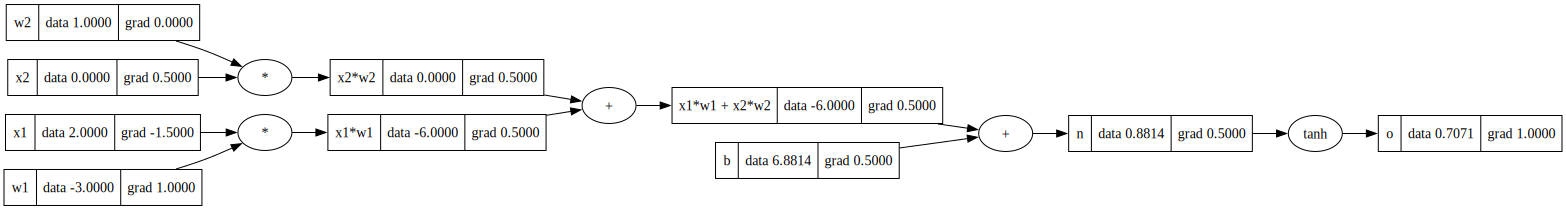

In [511]:
o.backward()
draw_dot(o)

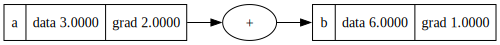

In [272]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

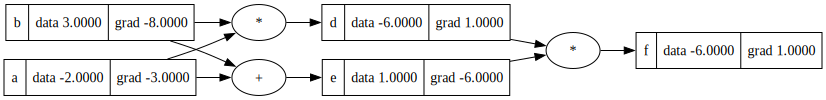

In [512]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

## Let's break up tanh
- prove this is all atomic
- add a few more operations
- handle the case where `other` is not an instance of value
- we need to implement a few other primitives first (sub, div, pow, etc)

In [274]:
a * Value(3.0)

Value(data=-6.0)

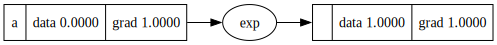

In [275]:
a = Value(0.0, label='a')
b = a.exp()

b.backward()
draw_dot(b)

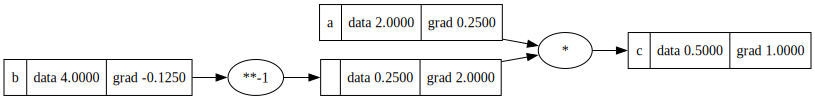

In [276]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
c = a / b; c.label="c" # a * 1/b => a * (b ** -1)
c.backward()
draw_dot(c)

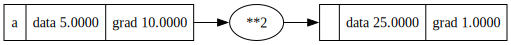

In [277]:
a = Value(5.0, label='a')
b = a**2
b.backward()
draw_dot(b)

## Now let's actually break up the tanh

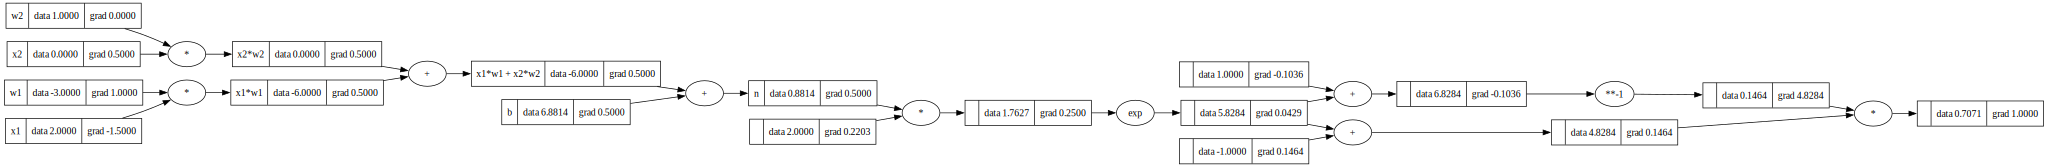

In [278]:
# same as before
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh => e^2x-1/e^2x+1
e = (2*n).exp()
o = (e-1)/(e+1)
(n,o)
o.backward()
draw_dot(o)

all that matters is: can we do a forward pass and a backpass?
doesn't matter how big or granular the operation is

## Let's do the same thing with PyTorch

In [513]:
import torch

# remember, tensors are just n-dimensional arrays of scalars!
# usually you would do like `torch.Tensor([[1,2,3],[4,5,6]])

# we cast to double here because python uses double by default and we just
# want this pytorch example to behave the same as the python code above

# we need to declare that leaf nodes require gradients because usually
# there is no point in computing them. so it's omitted for efficiency by default.

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad  = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# just like our Value, tensors have a .data and a .data

print(o.data.item()) # .item() takes a tensor of 1 element and strips out that element
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Now let's build out a Neural Network

Remember, a Neural Network is just a specific class of mathematical expression

- we will go piece by piece
- eventually a 2 layer multi-layer perceptron

In [1217]:
# a single neuron that subscribes to the pytorch api

class Neuron:
    # nin: number of inputs - w0x0, w1x1, etc
    def __init__(self, nin):
        # weight
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # bias
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # multiply all the elements of w with all the elements of x, pair wise
        # raw activation
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        # pass that through a nonlinearity
        out = act.tanh()
        return out

    # same name as in pytorch
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9974094232703216)

![a](./_resources/neural_net2.jpg)

each layer has multiple neurons!

they're not connected to each other, but they're connected to the input

so a layer of neurons is just a set of neurons, evaluated independently

In [1218]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # long form version:
        # params = []
        # for neuron in self.neurons
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

n = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.8995871723766652),
 Value(data=-0.7044180735408372),
 Value(data=0.997784588896233)]

In [1219]:
# multi layer perceptron
class MLP:
    # nouts is a list, defines the sizes of all the layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.23342307877190455)

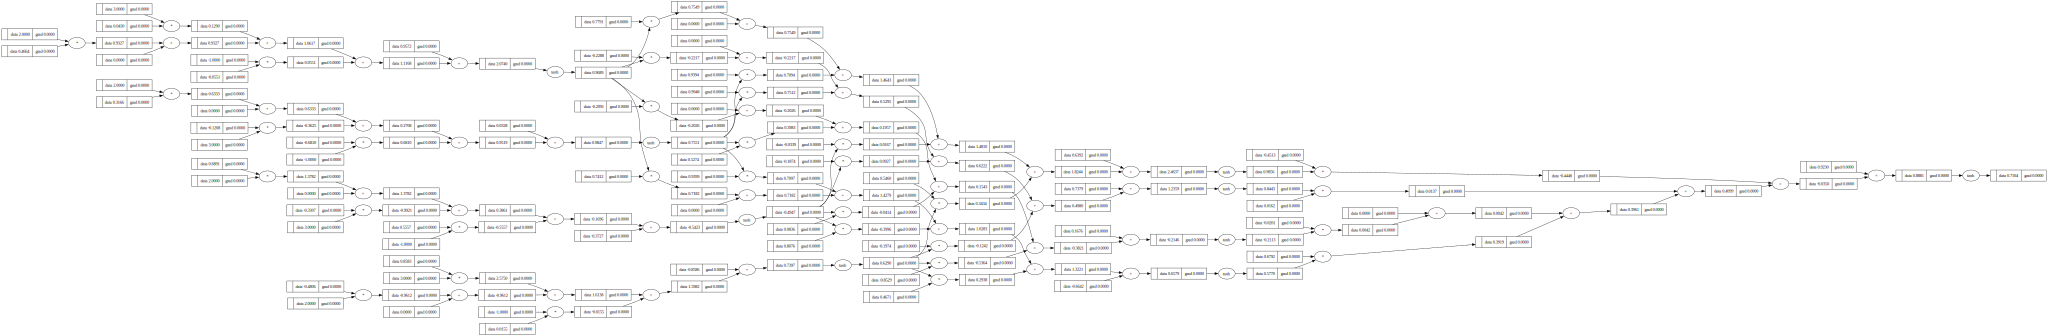

In [518]:
draw_dot(n(x))

In [1220]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

## Loss Function

how do we tune the weights to better predict the desired targets?

calculate a single number that somehow predicts the overall performance of the neural net.

this single number is called the "loss"

example here: mean square error loss

In [472]:
# y ground truth, y output
ypred = [n(x) for x in xs] # current predictions
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# the lower the loss, the more closely out predictions match the target
loss

Value(data=4.003860394508591)

In [473]:
loss.backward()

In [365]:
n.layers[0].neurons[0].w[0].grad

-2.586680242577641

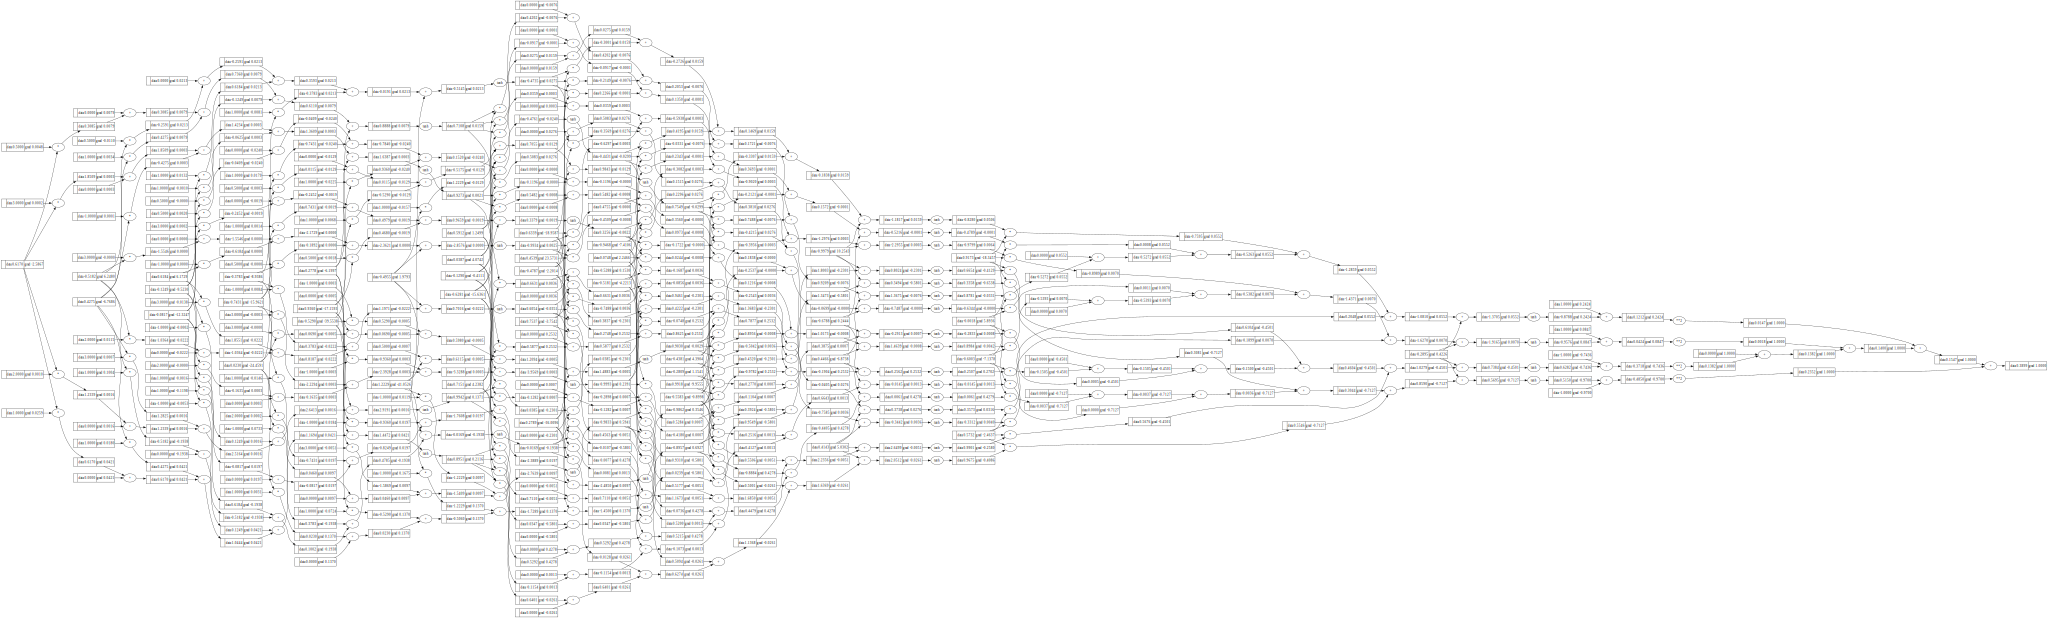

In [366]:
draw_dot(loss)

## Adding some convenience code to gather up all the parameters of the neural net

- so that we can operate on all of them simultaneously
- every one of them we will nudge a tiny amount based on the gradient information
- Neuron.parameters

In [367]:
# all the weights and biases in this neural net
n.parameters()

[Value(data=0.6169518408426721),
 Value(data=0.4274858100442787),
 Value(data=-0.12494037024646856),
 Value(data=0.27779186344276535),
 Value(data=-0.5181915897878866),
 Value(data=0.6183683905092277),
 Value(data=-0.3783492909972359),
 Value(data=-0.4954628251830959),
 Value(data=-0.0817268952980533),
 Value(data=-0.7431243683473321),
 Value(data=0.9359662248158119),
 Value(data=-0.6280616087011863),
 Value(data=0.022998205833703517),
 Value(data=-0.5289726313318205),
 Value(data=1.2229463775774523),
 Value(data=0.27887116929112343),
 Value(data=0.5911545462558955),
 Value(data=0.4538810873758907),
 Value(data=0.07480989756777816),
 Value(data=0.9918377658486967),
 Value(data=0.44659087221210203),
 Value(data=-0.12896115030052888),
 Value(data=-0.4786863102595568),
 Value(data=-0.5288114872315122),
 Value(data=-0.2809229464282469),
 Value(data=-0.6787809502493097),
 Value(data=0.038720093764033924),
 Value(data=0.6338636817536575),
 Value(data=-0.9467639384968178),
 Value(data=-0.4380

Now we can do this over and over... 
- calculate the loss
- backpropagate
- nudge the parameters

what am i changing here? parameters? weights? hopefuly weights?

inputs: xs
parameters: weights and biases

TODO: CHECK APPLE NOTES FOR QUESTIONS. AND WRITE REVIEW

In [1225]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

step = 0

In [1226]:
# gradient descent

learning_rate = 0.05 # if we make too large of a step, we may overstep...

print("targets", ys)

for k in range(20):
    step += 1

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0  # Reset gradients to avoid accumulation (all the operations on p.grad are +=)
    
    loss.backward()

    # update
    for p in n.parameters():
        # -1 because we want to minimize the loss, not maximize it
        # The gradient of a loss function L with respect to a parameter w (i.e., dL/dw)
        # is a vector pointing in the direction that increases the loss the most.
        # "the gradient vectors are pointing in the direction of increasing the loss"
        p.data += learning_rate * p.grad * -1

    print("step", step)
    print("    curr:", [value.data for value in ypred])
    print("    loss:", loss.data)

targets [1.0, -1.0, -1.0, 1.0]
step 1
    curr: [0.9695024828528568, 0.1548777986656592, 0.936937174485002, 0.6802344505499645]
    loss: 5.188648452920006
step 2
    curr: [0.9619515704905035, -0.656223246532875, 0.8936979052858479, 0.5517484067631732]
    loss: 3.9066513865358976
step 3
    curr: [0.9586413368272168, -0.7245793517688447, 0.8448533608221788, 0.6248622060263439]
    loss: 3.6217793598958195
step 4
    curr: [0.9427842690455052, -0.769530469251277, 0.6855150734926732, 0.5725206106507794]
    loss: 3.080089535761588
step 5
    curr: [0.8909087132713944, -0.8114532535496486, 0.13531645028034783, 0.3762943660057427]
    loss: 1.725402944590464
step 6
    curr: [0.8458285794284999, -0.8531366018084735, -0.421054867000505, 0.3190437733840729]
    loss: 0.8442165342402019
step 7
    curr: [0.9128787889851009, -0.859095768634025, -0.4056634899070211, 0.6853329123147278]
    loss: 0.47969537112737126
step 8
    curr: [0.9050952172202184, -0.8881121772553275, -0.6073973118228214